# Porting DAG into flex attention mask_mod function

In [2]:
import torch
import torch.nn.functional as F

from torch.nn.attention.flex_attention import (
    create_mask,
    flex_attention,
)

In [3]:
def build_adjacency_matrix(nodes):
    node_to_index = {node.id: idx for idx, node in enumerate(nodes)}
    n = len(nodes)
    
    # Initialize adjacency matrix with zeros
    adj_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        adj_matrix[i][i] = 1
    # Fill the adjacency matrix
    for node in nodes:
        current_idx = node_to_index[node.id]
        for parent in node.parents:
            parent_idx = node_to_index[parent.id]
            # Mark edge from parent to current node
            adj_matrix[current_idx][parent_idx] = 1
    
    return adj_matrix

In [1]:
from node import ICLNode, upstream_nodes, print_dag, build_attention_matrix, prepare_inputs
from viz_utils import visualize_attention_matrix
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

/home/xwang3_umass_edu/work/anaconda3/lib/python3.9/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Generate an attention matrix with a binary matrix

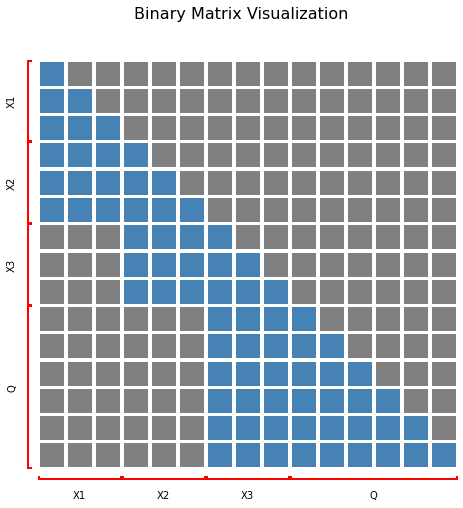

In [4]:
X1 = ICLNode('example1.', id='X1')
X2 = ICLNode('example2.', parents=[X1], id='X2')
X3 = ICLNode('example3.', parents=[X2], id='X3')
Q = ICLNode('What does the fox say?', parents=[X3], id='Q')

attention_mask, all_nodes, start_end_pos, names = build_attention_matrix(Q, tokenizer)
visualize_attention_matrix(attention_mask, start_end_pos, names, size_ratio=0.5)

Turn the DAG into a mask_mod function of signature `mask_mod(b, h, q_idx, kv_idx) => bool
`

In [6]:
def _offsets_to_doc_ids_tensor(offsets):
    device = offsets.device
    counts = offsets[1:] - offsets[:-1]
    return torch.repeat_interleave(
        torch.arange(len(counts), device=device, dtype=torch.int32), counts
    )


def generate_flex_attention_mask(leaf_node, tokenizer):
    _, all_nodes, start_end_pos, names = build_attention_matrix(leaf_node, tokenizer)
    node_id = _offsets_to_doc_ids_tensor(torch.tensor([0] + [end for (start, end) in start_end_pos]))
    adjancey_matrix = torch.tensor(build_adjacency_matrix(all_nodes), dtype=torch.int32)
    def document_causal_mask(b, h, q_idx, kv_idx):
        causal_mask = q_idx >= kv_idx
        node_mask = adjancey_matrix[node_id[q_idx], node_id[kv_idx]]
        return causal_mask & node_mask

    return document_causal_mask

In [8]:
mask_mod = generate_flex_attention_mask(Q, tokenizer)
mask = create_mask(mask_mod, 1, 1, attention_mask.shape[0], attention_mask.shape[0], "cpu")
print(mask)

tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]], dtype=torch.int32)


The mask we get is the same as the one constructed via LE ATTENTION's built-in function.